# Iteration 6: includes Audit class to record delays and calculate delay probabilities aslo it includes multiple repllicates run function of the model. 


---

## **. Patient Admission Sources**  
Patients enter the hospital through **two primary pathways**:  
- **New Admissions**: Direct hospital entry for Stroke, TIA, Complex Neurological, and Other Medical Cases.  


| Patient Type                     | Admissions (n) | Percentage (%) |
|----------------------------------|---------------|--------------|
| Stroke                           | 1,320         | 54%          |
| Transient Ischemic Attack (TIA)  | 158           | 6%           |
| Complex Neurological             | 456           | 19%          |
| Other Medical Cases              | 510           | 21%          |

**Patient admissions are distributed as follows**

| Category                | Mean(Days) |
|-------------------------|----------------------------|
| Stroke                  | 1.2                        |
| TIA (Transient Ischemic Attack) | 9.3                |
| Complex Neurological    | 3.6                        |
| Other                   | 3.2                        |



## **Patient Transfer Probabilities**  

### **From Acute Stroke Unit**  
| Destination  | Stroke | TIA | Complex Neurological | Other |
|-------------|--------|-----|----------------------|-------|
| **Rehab**   | 24%    | 1%  | 11%                  | 5%    |
| **ESD**     | 13%    | 1%  | 5%                   | 10%   |
| **Other***  | 63%    | 98% | 84%                  | 85%   |

**Other includes home, care home, or mortality.**


## 1. Imports 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import itertools
import simpy
import os
import sys

In [4]:
# Add parent directory to path so we can import distribution.py
sys.path.append(os.path.abspath(".."))  # noqa: E402

from distribution import Exponential, Lognormal  # noqa: E402

## 2. Constants

In [5]:
# Model parameters

# RUN_LENGTH
WARM_UP_PERIOD = 0

DEFAULT_RESULTS_COLLECTION_PERIOD = 365 * 10

RUN_LENGTH = DEFAULT_RESULTS_COLLECTION_PERIOD + WARM_UP_PERIOD

# default number of repetitions
DEFAULT_N_REPS = 5

# default mean inter-arrival times(exp)
IAT_STROKE = 1.2
IAT_TIA = 9.3
IAT_COMPLEX_NEURO = 3.6
IAT_OTHER = 3.2

# Default Length of Stay (LOS) parameters
# (mean, stdev for Lognormal distribution
LOS_STROKE = (7.4, 8.6)
LOS_TIA = (1.8, 2.3)
LOS_COMPLEX_NEURO = (4.0, 5.0)
LOS_OTHER = (3.8, 5.2)
LOS_STROKE_NESD = (7.4, 8.6)
LOS_STROKE_ESD = (4.6, 4.8)
LOS_STROKE_MORTALITY = (7.0, 8.7)

# Acute Stroke Unit (ASU) bed capacity
ASU_BEDS = 10

# % where patients go after the Acute Stroke Unit (ASU)
TRANSFER_PROBABILITIES = {
    "stroke": {"rehab": 0.24, "esd": 0.13, "other": 0.63},
    "tia": {"rehab": 0.01, "esd": 0.01, "other": 0.98},
    "complex_neuro": {"rehab": 0.11, "esd": 0.05, "other": 0.84},
    "other": {"rehab": 0.05, "esd": 0.10, "other": 0.85},
}


# sampling settings, 4 for arrivals, 4 for LOS and
# for 4 transfer probabilities
N_STREAMS = 12
DEFAULT_RND_SET = 101

# Boolean switch to simulation results as the model runs
TRACE = False

## 2. Helper classes and functions

In [6]:
def trace(msg):
    """
    Turing printing of events on and off.

    Params:
    -------
    msg: str
        string to print to screen.
    """
    if TRACE:
        print(msg)

## 3. Audit Class

In [7]:
class Audit:
    """
    Records and analyzes the performance
    metrics of the Acute Stroke Unit model.
    """

    def __init__(self):
        self.delay_time = []  # Stores (patient_type, delay_occurred)
        self.performance_metrics = []
        self.bed_occupancy = {
            "Patient Type": [],
            "Occupied beds": [],
            "Waiting patients": [],
            "Bed utilization": [],
            "Total beds": [],
            "Timestamp": [],
        }

    def record_bed_occupancy(
        self,
        patient_type,
        occupied_beds,
        waiting_patients,
        bed_utilization,
        timestamp,
        total_beds,
    ):
        """
        Records the bed occupancy of the unit.

        Parameters
        ----------
        patient_type : str
            The type of patient (e.g., 'stroke', 'TIA', etc.).
        occupied_beds : int
            Number of beds currently occupied.
        waiting_patients : int
            Number of patients waiting for a bed.
        bed_utilization : float
            The fraction of occupied beds (e.g., 0.7 for 70% occupied).
        timestamp : float
            The current simulation time.
        total_beds : int
            Total number of beds in the unit.
        """
        self.bed_occupancy["Patient Type"].append(patient_type)
        self.bed_occupancy["Occupied beds"].append(occupied_beds)
        self.bed_occupancy["Waiting patients"].append(waiting_patients)
        self.bed_occupancy["Bed utilization"].append(bed_utilization)
        self.bed_occupancy["Total beds"].append(total_beds)
        self.bed_occupancy["Timestamp"].append(timestamp)

    def record_delay_probability(self, patient_type, waiting_time):
        """
        Records whether a delay occurred for a given patient type.

        Parameters
        ----------
        patient_type : str
            The type of patient (e.g., 'stroke', 'TIA', etc.).
        waiting_time : float
            The waiting time of the patient.
        """
        # Convert to boolean flag for delay
        delay_occurred = 1 if waiting_time > 0 else 0
        self.delay_time.append((patient_type, delay_occurred))

    def calculate_delay_time_by_patient_type(self):
        """
        Calculates the probability of delay for each patient type.

        Returns
        -------
        dict
            A dictionary with patient types as keys and
            the probability of delay as values.
        """
        delay_counts = {}
        total_counts = {}

        for patient_type, delay_occurred in self.delay_time:
            if patient_type not in delay_counts:
                delay_counts[patient_type] = 0
                total_counts[patient_type] = 0

            if delay_occurred:
                delay_counts[patient_type] += 1
            total_counts[patient_type] += 1

        delay_probabilities = {
            pt: (
                (delay_counts[pt] / total_counts[pt])
                if total_counts[pt] > 0
                else 0
            )
            for pt in delay_counts
        }
        return delay_probabilities

    def get_all_probabilities_of_delay(self):
        """
        Returns all calculated delay probabilities.
        """
        return self.calculate_delay_time_by_patient_type()

    def calculate_overall_delay_probability(self):
        """
        Calculates the overall delay probability.

        Returns
        -------
        float
            The overall probability of experiencing a delay.
        """
        total_patients = len(self.delay_time)
        if total_patients == 0:
            return 0  # Avoid division by zero

        total_delay_count = sum(
            1 for _, delay_occurred in self.delay_time if delay_occurred
        )
        overall_delay_probability = total_delay_count / total_patients
        return overall_delay_probability

    def get_overall_delay_probability(self):
        """
        Returns the overall delay probability.
        """
        return self.calculate_overall_delay_probability()

## 4. Experiment class

In [8]:
class Experiment:
    """
    Encapsulates the concept of an experiment for
    the Acute Stroke Unit simulation.
    Manages parameters, PRNG streams, and results.
    """

    def __init__(
        self,
        random_number_set=DEFAULT_RND_SET,
        n_streams=N_STREAMS,
        iat_stroke=IAT_STROKE,
        iat_tia=IAT_TIA,
        iat_complex_neuro=IAT_COMPLEX_NEURO,
        iat_other=IAT_OTHER,
        asu_beds=ASU_BEDS,
        los_stroke=LOS_STROKE,
        los_tia=LOS_TIA,
        los_complex_neuro=LOS_COMPLEX_NEURO,
        los_other=LOS_OTHER,
        transfer_probabilities=TRANSFER_PROBABILITIES,
    ):
        """
        Initialize default parameters.
        """
        # Sampling settings
        self.random_number_set = random_number_set
        self.n_streams = n_streams

        # Model parameters
        self.iat_stroke = iat_stroke
        self.iat_tia = iat_tia
        self.iat_complex_neuro = iat_complex_neuro
        self.iat_other = iat_other
        self.asu_beds = asu_beds

        # LOS Parameters
        self.los_stroke = los_stroke
        self.los_tia = los_tia
        self.los_complex_neuro = los_complex_neuro
        self.los_other = los_other

        # Transfer probabilities
        self.transfer_probabilities = transfer_probabilities

        # Initialize results storage
        self.init_results_variables()

        # Initialize sampling distributions (RNGs)
        self.init_sampling()

        # Audit object
        self.audit = Audit()

    def set_random_no_set(self, random_number_set):
        """
        Controls the random sampling by re-seeding.
        """
        self.random_number_set = random_number_set
        self.init_sampling()

    def init_sampling(self):
        """
        Creates the distributions used by the model and initializes
        the random seeds of each.
        """
        # Create a new seed sequence
        seed_sequence = np.random.SeedSequence(self.random_number_set)
        # Produce n non-overlapping streams
        self.seeds = seed_sequence.spawn(self.n_streams)

        # Prepare a list of RNGs
        rng_list = [np.random.default_rng(s.entropy) for s in self.seeds]

        # Inter-arrival time distributions
        self.arrival_stroke = Exponential(self.iat_stroke, self.seeds[0])
        self.arrival_tia = Exponential(self.iat_tia, self.seeds[1])
        self.arrival_complex_neuro = Exponential(
            self.iat_complex_neuro, self.seeds[2]
        )
        self.arrival_other = Exponential(self.iat_other, self.seeds[3])

        # LOS distributions using stored parameters
        self.los_distributions = {
            "stroke": Lognormal(
                self.los_stroke[0], self.los_stroke[1], self.seeds[4]
            ),
            "tia": Lognormal(self.los_tia[0], self.los_tia[1], self.seeds[5]),
            "complex_neuro": Lognormal(
                self.los_complex_neuro[0],
                self.los_complex_neuro[1],
                self.seeds[6],
            ),
            "other": Lognormal(
                self.los_other[0], self.los_other[1], self.seeds[7]
            ),
        }

        # RNGs specifically for transfer choices (1 per patient type)
        self.transfer_rngs = {
            "stroke": rng_list[8],
            "tia": rng_list[9],
            "complex_neuro": rng_list[10],
            "other": rng_list[11],
        }

    def init_results_variables(self):
        """
        Initializes all the experiment variables used in results collection.
        """
        self.results = {
            "n_stroke": 0,
            "n_tia": 0,
            "n_complex_neuro": 0,
            "n_other": 0,
            "n_patients": 0,
            "n_stroke_discharged": 0,
            "n_tia_discharged": 0,
            "n_complex_neuro_discharged": 0,
            "n_other_discharged": 0,
            "n_discharged": 0,
            "stroke_transfer": {"rehab": 0, "esd": 0, "other": 0},
            "tia_transfer": {"rehab": 0, "esd": 0, "other": 0},
            "complex_neuro_transfer": {"rehab": 0, "esd": 0, "other": 0},
            "other_transfer": {"rehab": 0, "esd": 0, "other": 0},
            "total_transfers": {"rehab": 0, "esd": 0, "other": 0},
        }

## 5. Patient Class

In [9]:
class Patient:
    """
    Represents a patient in the system.
    """

    def __init__(self, patient_id, env, args, acute_stroke_unit, patient_type):
        self.patient_id = patient_id
        self.env = env
        self.args = args
        self.acute_stroke_unit = acute_stroke_unit
        self.patient_type = patient_type
        self.waiting_time = 0.0  # track how long the patient waited for a bed

    def treatment(self):
        """
        Simulates the patient’s treatment process.
        Upon discharge, calls `transfer()` to determine next destination.
        """
        arrival_time = self.env.now
        los_distribution = self.args.los_distributions[self.patient_type]

        # Arrival message
        trace(
            f"Patient {self.patient_id} ({self.patient_type.upper()}) \
            arrives at {arrival_time:.2f}."
        )

        # Request bed from the ASU
        with self.acute_stroke_unit.beds.request() as request:
            yield request
            self.waiting_time = self.env.now - arrival_time
            self.args.audit.record_delay_probability(
                self.patient_type, self.waiting_time
            )
            los = los_distribution.sample()

            # Bed assigned message
            trace(
                f"Patient {self.patient_id} ({self.patient_type.upper()})"
                f"gets a bed at {self.env.now:.2f}."
                f" (Waited {self.waiting_time:.2f} days)"
            )

            if self.waiting_time > 0:
                trace(
                    f"Patient {self.patient_id}"
                    f"({self.patient_type.upper()})  had a delay.)"
                )

            # Simulate length of stay
            yield self.env.timeout(los)

            # Leaving message
            trace(
                f"Patient {self.patient_id} ({self.patient_type.upper()})"
                f" leaves at {self.env.now:.2f}."
                f" (LOS {los:.2f} days)"
            )

            # record the the beds occupancy
            occupied_beds = self.acute_stroke_unit.beds.count
            total_beds = self.acute_stroke_unit.beds.capacity
            waiting_patients = len(self.acute_stroke_unit.beds.queue)
            timestamp = self.env.now
            # Avoid division by zero
            utilization = occupied_beds / total_beds if total_beds > 0 else 0

            self.args.audit.record_bed_occupancy(
                self.patient_type,
                occupied_beds,
                waiting_patients,
                utilization,
                timestamp,
                total_beds,
            )

            self.args.results["n_discharged"] += 1
            self.args.results[f"n_{self.patient_type}_discharged"] += 1

            # Transfer the patient after discharge
            self.transfer()

    def transfer(self):
        """
        Determines the patient's next destination
        based on the transfer probabilities.
        Logs and updates the experiment's results.
        """
        # Access the RNG and probabilities for this patient type
        rng = self.args.transfer_rngs[self.patient_type]
        p_dict = self.args.transfer_probabilities[self.patient_type]
        destinations = list(p_dict.keys())
        probs = list(p_dict.values())

        # Random draw for the transfer destination
        destination = rng.choice(destinations, p=probs)
        trace(
            f"Patient {self.patient_id} ({self.patient_type.upper()})\
            is transferred to {destination.upper()}."
        )

        # Update results
        self.args.results["total_transfers"][destination] += 1
        self.args.results[f"{self.patient_type}_transfer"][destination] += 1

## 6. Acute Stroke Unit Class


In [10]:
class AcuteStrokeUnit:
    """
    Models the Acute Stroke Unit (ASU) in the hospital.
    """

    def __init__(self, env, args):
        self.env = env
        self.args = args
        self.beds = simpy.Resource(env, capacity=args.asu_beds)

    def patient_arrivals(self, patient_type, arrival_distribution):
        """
        A generator that creates patients of 'patient_type' according to
        the given 'arrival_distribution' (Exponential).
        """
        for patient_count in itertools.count(start=1):
            inter_arrival_time = arrival_distribution.sample()
            yield self.env.timeout(inter_arrival_time)

            # Track patient count
            self.args.results[f"n_{patient_type}"] += 1
            self.args.results["n_patients"] += 1

            trace(f"{self.env.now:.2f}: {patient_type.upper()} arrival.")

            # Create new patient and start its treatment process
            new_patient = Patient(
                patient_count, self.env, self.args, self, patient_type
            )
            self.env.process(new_patient.treatment())

## 7. Single run function

In [11]:
def single_run(experiment, rep=0, run_length=RUN_LENGTH):
    """
    Perform a single run of the model and return the results.

    Parameters
    ----------
    experiment : Experiment
        The experiment/parameters to use with model
    rep : int
        The replication number (used to set random seeds).
    run_length : float
        The run length of the model in days (default = 3650 = 10 years).
    """
    # 1. Reset results for each run
    experiment.init_results_variables()

    # 2. Set the random number set for this run
    experiment.set_random_no_set(rep)

    # 3. Create a fresh environment and an AcuteStrokeUnit
    env = simpy.Environment()
    asu = AcuteStrokeUnit(env, experiment)

    # 4. Create patient arrival processes for different types of patients
    env.process(asu.patient_arrivals("stroke", experiment.arrival_stroke))
    env.process(asu.patient_arrivals("tia", experiment.arrival_tia))
    env.process(
        asu.patient_arrivals("complex_neuro", experiment.arrival_complex_neuro)
    )
    env.process(asu.patient_arrivals("other", experiment.arrival_other))

    # 5. Run the simulation
    env.run(until=run_length)

    # 6. Trace summary of total patients
    total_patients = sum(
        experiment.results[key]
        for key in experiment.results
        if key.startswith("n_")
    )
    trace(f"Final summary for rep={rep}: {total_patients} total patients.")

    # Return the results dictionary

    return experiment.results

In [12]:
TRACE = False
experiment = Experiment()
overall_p = single_run(experiment)
# delay time by patient type
delay_time_pypatient = experiment.audit.calculate_delay_time_by_patient_type
delay_time = experiment.audit.delay_time  # delay time for each patient
bed_utilization = experiment.audit.bed_occupancy  # bed utilization

delay_time = experiment.audit.delay_time

In [13]:
delay_time[:10]

[('stroke', 0),
 ('other', 0),
 ('stroke', 0),
 ('other', 0),
 ('complex_neuro', 0),
 ('complex_neuro', 0),
 ('stroke', 0),
 ('stroke', 0),
 ('stroke', 0),
 ('tia', 0)]

In [14]:
overall_p

{'n_stroke': 3075,
 'n_tia': 421,
 'n_complex_neuro': 972,
 'n_other': 1184,
 'n_patients': 5652,
 'n_stroke_discharged': 3071,
 'n_tia_discharged': 421,
 'n_complex_neuro_discharged': 971,
 'n_other_discharged': 1184,
 'n_discharged': 5647,
 'stroke_transfer': {'rehab': 740, 'esd': 403, 'other': 1928},
 'tia_transfer': {'rehab': 5, 'esd': 5, 'other': 411},
 'complex_neuro_transfer': {'rehab': 90, 'esd': 43, 'other': 838},
 'other_transfer': {'rehab': 55, 'esd': 113, 'other': 1016},
 'total_transfers': {'rehab': 890, 'esd': 564, 'other': 4193}}

In [15]:
df = pd.DataFrame(bed_utilization)
df

,Patient Type,Occupied beds,Waiting patients,Bed utilization,Total beds,Timestamp
0,other,6,0,0.6,10,6.135526
1,stroke,5,0,0.5,10,6.190893
2,other,7,0,0.7,10,7.030382
3,stroke,7,0,0.7,10,7.490514
4,tia,6,0,0.6,10,8.524870
...,...,...,...,...,...,...
5642,complex_neuro,7,0,0.7,10,3647.600546
5643,stroke,6,0,0.6,10,3647.657590
5644,stroke,7,0,0.7,10,3647.822880
5645,stroke,7,0,0.7,10,3648.841655


## TEST - Should only show TIA patients

In [16]:
M = 1_000_000
experiment = Experiment(iat_stroke=M, iat_complex_neuro=M, iat_other=M)
results = single_run(experiment)
results

{'n_stroke': 0,
 'n_tia': 421,
 'n_complex_neuro': 0,
 'n_other': 0,
 'n_patients': 421,
 'n_stroke_discharged': 0,
 'n_tia_discharged': 421,
 'n_complex_neuro_discharged': 0,
 'n_other_discharged': 0,
 'n_discharged': 421,
 'stroke_transfer': {'rehab': 0, 'esd': 0, 'other': 0},
 'tia_transfer': {'rehab': 5, 'esd': 5, 'other': 411},
 'complex_neuro_transfer': {'rehab': 0, 'esd': 0, 'other': 0},
 'other_transfer': {'rehab': 0, 'esd': 0, 'other': 0},
 'total_transfers': {'rehab': 5, 'esd': 5, 'other': 411}}

### 8. Multiple replications run function

In [17]:
def multiple_replications(
    scenario,
    rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
    n_reps=DEFAULT_N_REPS,
):
    """
    Perform multiple replications of the model.

    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configure the model

    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.
        the number of minutes to run the model beyond warm up
        to collect results

    warm_up: float, optional (default=0)
        initial transient period.  no results are collected in this period

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.

    n_jobs, int, optional (default=-1)
        No. replications to run in parallel.

    Returns:
    --------
    List
    """
    summary_list = []
    rep_results = []
    overall = []
    reps = []
    for rep in range(n_reps):
        print(f"Replication {rep+1} of {n_reps}")
        # Create a new experiment with the current bed capacity
        exp_temp = Experiment()
        # Run the simulation using the default run
        # length and current replication number
        res = single_run(exp_temp, rep=rep, run_length=rc_period)
        rep_results.append(res["n_discharged"])
        ovell_p = exp_temp.audit.get_overall_delay_probability()
        overall.append(ovell_p)
        info = f"Rep {rep+1} of {n_reps}"
        reps.append(info)
    print("Replications Run Completed")
    summary_list.append(
        {"Patients": rep_results, "Delay Probability": overall, "Rep": reps}
    )

    # format and return results in a dataframe

    df = pd.DataFrame()
    df["Patients"] = rep_results
    df["Overall Delay Probability"] = overall
    df[f"Reps:{n_reps}"] = reps
    df = df.set_index(f"Reps:{n_reps}")
    return df

In [18]:
TRACE = False
experiment = Experiment()
results_df = multiple_replications(experiment)

Replication 1 of 5
Replication 2 of 5
Replication 3 of 5
Replication 4 of 5
Replication 5 of 5
Replications Run Completed


In [19]:
results_df

,Patients,Overall Delay Probability
Reps:5,,
Rep 1 of 5,5647,0.650920
Rep 2 of 5,5588,0.621472
Rep 3 of 5,5599,0.600464
Rep 4 of 5,5486,0.474709
Rep 5 of 5,5669,0.593904


In [20]:
results_df.mean()

Patients                     5597.800000
Overall Delay Probability       0.588294
dtype: float64

In [21]:
def multiple_runs(rep, beds_start, beds_end):
    """
    This function runs the simulation multiple times and
    returns the average delay probability of each bed incrementally.
    """

    def run_single_experiment(bed, rep):
        experiment = Experiment(asu_beds=bed)
        res = single_run(experiment, rep=rep)
        overall_p = experiment.audit.get_overall_delay_probability()
        return res["n_discharged"], overall_p

    summary_list = []

    for bed in range(beds_start, beds_end + 1):
        print(
            f"Running experiment with {bed}"
            f"beds and {rep} repetitions, end={beds_end}"
        )
        results = Parallel(n_jobs=-1)(
            delayed(run_single_experiment)(bed, rep) for rep in range(rep)
        )
        rep_results, overall = zip(*results)

        overall_avg = np.mean(overall)
        avg_patients = np.mean(rep_results)
        summary_list.append(
            {
                "Bed Capacity": bed,
                "Avg. Patients": avg_patients,
                "Overall Delay Probability": overall_avg,
                "1 in very n Patients": (
                    1 / overall_avg if overall_avg != 0 else float("inf")
                ),
            }
        )

    print("Finished running all experiments")
    summary_df = pd.DataFrame(summary_list)
    return summary_df

In [22]:
df = multiple_runs(5, 9, 17)

Running experiment with 9beds and 5 repetitions, end=17


Running experiment with 10beds and 5 repetitions, end=17
Running experiment with 11beds and 5 repetitions, end=17
Running experiment with 12beds and 5 repetitions, end=17
Running experiment with 13beds and 5 repetitions, end=17
Running experiment with 14beds and 5 repetitions, end=17
Running experiment with 15beds and 5 repetitions, end=17
Running experiment with 16beds and 5 repetitions, end=17
Running experiment with 17beds and 5 repetitions, end=17
Finished running all experiments


In [23]:
df

,Bed Capacity,Avg. Patients,Overall Delay Probability,1 in very n Patients
0,9,5570.0,0.866465,1.154115
1,10,5597.8,0.588294,1.699831
2,11,5606.6,0.372628,2.683642
3,12,5610.8,0.227882,4.388234
4,13,5610.8,0.135090,7.402483
5,14,5610.8,0.078663,12.712486
6,15,5610.8,0.043489,22.994424
7,16,5610.8,0.023358,42.811638
8,17,5610.8,0.011771,84.951969


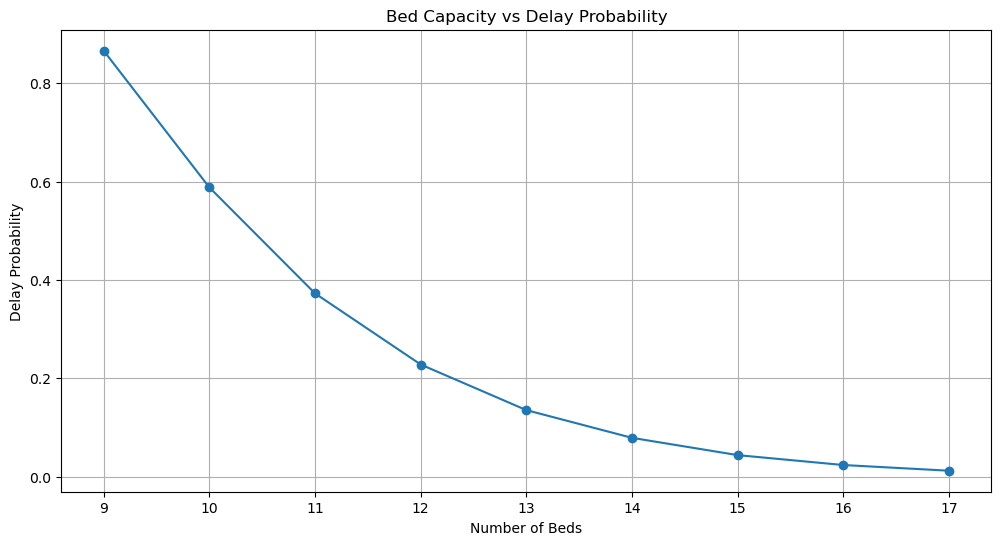

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(
    df["Bed Capacity"],
    df["Overall Delay Probability"],
    marker="o",
    linestyle="-",
)
plt.xlabel("Number of Beds")
plt.ylabel("Delay Probability")
plt.title("Bed Capacity vs Delay Probability")
plt.grid(True)
plt.show()